## Importance Sampling
In this notebook, I would like to introduce the method of importanece sampling, and show how this method can result in conventional Monte Carlo simulations for tail probabilities that require fewer trials than with brute-force sampling of the distribution.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

%matplotlib inline

## [Monte Carlo Simulation](https://en.wikipedia.org/wiki/Monte_Carlo_method)
In MC simulation, we just sample from a given distribution and see how much you can approximate the distribution by the random sampling. So to see how efficient this method is, I'd like to do some experiments.

### Experiment
We will apply MC to approximate the Gaussian Distribution with
- $\mu$: 0
- $\sigma$: 1  
which is simply saying Normal distribution.

So, as a first step, let's define the Gaussian function and plot it using

- Matplotlib
- Numpy
- Scipy

In [2]:
# instantiate the variables
Mu    = 0
Sigma = 1

### [Univariate Gaussian Distribution](https://en.wikipedia.org/wiki/Normal_distribution)
$$
f(x | \mu, \sigma^2) = \frac{1}{\sqrt{2\pi\sigma^2}} \exp \big(- \frac{ (x-\mu)^2}{\sigma^2} \big)
$$

In [3]:
# define Gaussian function
def Gaussian(Mu, Sigma, x):
  return np.array(((2*np.pi*Sigma**2)**-.5)*np.exp( -( x-Mu )**2/(2*Sigma**2) ))

In [4]:
# check if our Gaussian function is correctly implemented
assert Gaussian(Mu, Sigma, 1) == norm.pdf(1)

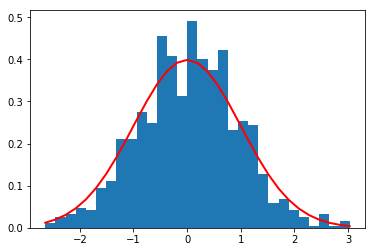

In [5]:
count, bins, ignored = plt.hist(np.random.normal(Mu, Sigma, 1000), 30, density=True)
plt.plot(bins, Gaussian(Mu, Sigma, bins),linewidth=2, color='r')

### MC Simulation
Simplified Formula is as follows
$$
P(X \leq \gamma) = \int^{\infty}_{\gamma} f_X(x) dx = p_{\gamma} \\
\hat{p}_{\gamma} = \frac{1}{K} \sum^K_{k=1} u(X_k - \gamma) \\
E[\hat{p}_{\gamma}] = p_{\gamma} \\
\text{Var}[\hat{p}_{\gamma}] = \frac{p_{\gamma} (1 - p_{\gamma})}{K}
$$

where

- $f_X(x)$: Target function/Distribution which takes $x$ as an input
- $\gamma$: threshold
- $u$: [Indicator Function](https://en.wikipedia.org/wiki/Indicator_function)
- $X$: Random Variable

Before jumping into the simulation, let's have some visual aid to enhance our understanding.  
Let's say, we set a value between 1 to 2 to gamma, then the resultant distribution will look like below

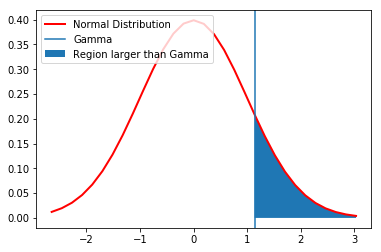

In [6]:
values = bins # one of the output of plt.hist
index_of_gamma = 20
gamma = values[index_of_gamma]

plt.plot(bins, Gaussian(Mu, Sigma, values),linewidth=2, color='r', label="Normal Distribution")
plt.fill_between(values[index_of_gamma:], Gaussian(Mu, Sigma, values[index_of_gamma:]), label="Region larger than Gamma")
plt.axvline(x=values[index_of_gamma], label="Gamma")
plt.legend(loc='upper left')

So, through the process and maths described aboeve, we will approximate the region, which is filled with blue.  
But, you might wonder what exactly I meant by `approximate` the region, because the region is a 2D area so that it is hardly caculatable by Programming Language. Indeed, the answer is yes we can!  

It is because, the region can be considered as the probability that we get some values larger than the threshold($\gamma$). So what we needed to do is just a calculation of CDF(Cumulative density function) of a given distribution.

To do this, we will use some useful APIs of [Scipy](https://docs.scipy.org/doc/scipy-0.16.1/reference/generated/scipy.stats.norm.html), which are 
- `norm.cdf`: Cumulative density function.
- `norm.ppf`: Percent point function (inverse of cdf — percentiles).

In [10]:
# use case
temp1 = norm.cdf(gamma)
temp2 = norm.ppf(temp1)
# check if the gamma and inverted ppf do match
assert round(gamma, 3) == round(temp2, 3)

In [11]:
gamma, norm.cdf(gamma), norm.ppf(temp1)

(1.138219229588418, 0.8724855245025238, 1.1382192295884177)

In [38]:
larger_than_gamma = norm.cdf(gamma) # probability that we get bigger value than gamma
for i in range(1,13):
  MC_region = np.mean( np.random.normal(Mu, Sigma, 10^i) - gamma > 0 )
  print(MC_region, 1-larger_than_gamma)
  if MC_region > 1-larger_than_gamma:
    print("done")
    break
print(i)

0.09090909090909091 0.1275144754974762
0.0 0.1275144754974762
0.0 0.1275144754974762
0.0 0.1275144754974762
0.13333333333333333 0.1275144754974762
done
5


### Interpretation of this simulation result
What we have done above is that we have repeatedly obtained samples from the normal distribution, which has the mean of 0 and the variance of 1, and compared the observation with **Gamma**. Then if it is larger than Gamma, then we get 1 otherwise 0(Indicator Function). Then, we averaged the result to get the probability that we would obtain a sample which has a larger value than Gamma.

Finally, `MC_region > 1-larger_than_gamma` does confirm if our MC simulation could get the better result than the orignal disbtribution.

## Importance Sampling
Now, we will move on to do Importance Sampling. let's start with checking the formula.
$$
P[X \leq \gamma] = \int^{\infty}_{\gamma} f_X(x) dx \\
 = \int^{\infty}_{\gamma} \frac{f_X(x)}{f_Y(x)} f_Y(x) dx = p_{\gamma} \\
\hat{p}_{\gamma} = \frac{1}{K} \sum^K_{k=1} \frac{u(Y_k - \gamma) f_X(Y_k)}{f_Y(Y_k)}\\
\text{Var}[\hat{p}_{\gamma}] = \frac{\text{Var}[ \frac{u(Y_k - \gamma) f_X(Y_k)}{f_Y(Y_k)} ]}{K}
$$
where

- $X$: Random variable => $X \sim N(0,1)$
- $Y$: Random variable => $Y \sim N(\gamma,1)$
- $f_Y$: Proposal Distribution
- $f_X$: Target Distribution

In [48]:
larger_than_gamma = norm.cdf(gamma) # probability that we get bigger value than gamma
for i in range(1,13):
  # at this point, we rather use more wide Gaussian Distribution with the variance of 10
  # the target distribution is Normal distribution, so we are 10 times likely to get larger value than gamma
  # compared to the target distribution, because the variance is 10 times bigger in Proposal distribution.
  MC_region = np.mean( np.random.normal(Mu, 10, 10^i) - gamma > 0 )
  print(MC_region, 1-larger_than_gamma)
  if MC_region > 1-larger_than_gamma:
    print("done")
    break
print(i)

0.5454545454545454 0.1275144754974762
done
1
